In [1]:
from fishsense_api_sdk.client import Client
from label_studio_sdk.client import LabelStudio
from synology_api.filestation import FileStation
from label_studio_sdk.core import ApiError
from tqdm.notebook import tqdm
from pathlib import Path
from tqdm.asyncio import tqdm_asyncio
from fishsense_api_sdk.models.dive_slate_label import DiveSlateLabel
from fishsense_data_processing_workflow_worker.config import settings
import pymupdf
import json
from datetime import datetime
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.exposure import adjust_gamma, equalize_adapthist
from skimage.util import img_as_float, img_as_ubyte
import rawpy
import math
import random
import matplotlib

In [2]:
URL = "http://localhost:8000"

NAS_HOST = "e4e-nas.ucsd.edu"
NAS_PORT = 6021

In [3]:
DATA_FOLDER = (Path("../data") / "REEF" / "data").absolute()
OUTPUT_FOLDER = (Path("../output") / "preprocess_slate_images_jpeg").absolute()

DATA_FOLDER.mkdir(parents=True, exist_ok=True)
OUTPUT_FOLDER.mkdir(parents=True, exist_ok=True)

DATA_FOLDER.exists(), OUTPUT_FOLDER.exists()

(True, True)

In [4]:
label_studio_api_key = Path("..") / ".label_studio_api_key"

label_studio_api_key.exists()

True

In [5]:
ls = LabelStudio(base_url=f"https://labeler.e4e.ucsd.edu", api_key=label_studio_api_key.read_text().strip())

In [6]:
filestation = FileStation(NAS_HOST, NAS_PORT, settings.e4e_nas.username, settings.e4e_nas.password, secure=True, cert_verify=False)

ValidationError: fishsense_api.username cannot exists in env main

In [ ]:
async with Client(URL) as fs:
    dives = await fs.dives.get_canonical()

len(dives), dives[0]

(272,
 Dive(id=1, name='080123_FSL-01 Photos', path='2023-09-07 REEF Data Dump/080123_FSL-01 Photos', dive_datetime=datetime.datetime(2023, 8, 1, 12, 46, 27, tzinfo=TzInfo(0)), priority=<Priority.LOW: 'LOW'>, flip_dive_slate=True, camera_id=1, dive_slate_id=1, laser_calibration_id=None))

In [ ]:
async with Client(URL) as fs:
    slate_labels = await tqdm_asyncio.gather(*[fs.labels.get_dive_slate_labels(dive.id) for dive in dives])
    dive_id_by_slate_label_id = {label.id: dive.id for dive, labels in zip(dives, slate_labels) for label in labels}

    slate_labels = [label for sublist in slate_labels for label in sublist]

len(slate_labels), slate_labels[0] 

  0%|          | 0/272 [00:00<?, ?it/s]

100%|██████████| 272/272 [00:05<00:00, 46.55it/s]


(95,
 DiveSlateLabel(id=1, label_studio_task_id=223832, label_studio_project_id=66, image_url='https://orchestrator.fishsense.e4e.ucsd.edu/api/v1/data/dive_slate_jpgs/2863b55ffedf2bbb1e94f8042fd8ad60', upside_down=True, reference_points=[(2321.9457453264135, 959.2893372588877), (2171.3246002578503, 959.2893372588877), (2000.620635846813, 962.636473815967), (1852.0077727124985, 963.9753284387986), (2312.5737629665905, 656.0387651875158), (2160.6137632751975, 660.0553290560107), (1997.9429266011498, 663.4024656130898), (1849.9994907782498, 668.0884567930008)], slate_rectangle=[(5500.731058298862, 364.71883205108514), (6472.669253882198, 1077.0831721874667)], skipped_points=None, updated_at=datetime.datetime(2025, 11, 24, 1, 32, 22, 408431, tzinfo=TzInfo(0)), completed=True, label_studio_json={'annotations': [{'id': 130421, 'result': [{'id': '5dkO2_2wp4', 'type': 'choices', 'value': {'choices': ['Slate upside down']}, 'origin': 'manual', 'to_name': 'image', 'from_name': 'upside_down'}, {'

In [ ]:
label_studio_project_ids = list({label.label_studio_project_id for label in slate_labels if label.label_studio_project_id is not None})

len(label_studio_project_ids), label_studio_project_ids

(1, [66])

In [ ]:
async with Client(URL) as fs:
    dive_slates = await fs.dive_slates.get()

len(dive_slates), dive_slates[0]

(11,
 DiveSlate(id=5, name='Tic-Tac-Toe 4', dpi=300, path='Dive Slate#4.pdf', created_at=datetime.datetime(2025, 9, 6, 3, 53, 10, 190057, tzinfo=TzInfo(0)), reference_points=[(591.9493127134886, 419.73291956851295), (1180.375218367864, 415.508647477124), (2008.7060450606716, 408.7832988960453), (2598.7223535242415, 401.20588324117523), (594.2177470825221, 1320.1595244257721), (1183.4343179108548, 1318.369903930235), (2016.1826073962275, 1316.5857288918276), (2604.907191981395, 1314.7051789793095)]))

In [ ]:
dive_slates_by_id = {dive_slate.id: dive_slate for dive_slate in dive_slates}

dive_slates_by_id

{5: DiveSlate(id=5, name='Tic-Tac-Toe 4', dpi=300, path='Dive Slate#4.pdf', created_at=datetime.datetime(2025, 9, 6, 3, 53, 10, 190057, tzinfo=TzInfo(0)), reference_points=[(591.9493127134886, 419.73291956851295), (1180.375218367864, 415.508647477124), (2008.7060450606716, 408.7832988960453), (2598.7223535242415, 401.20588324117523), (594.2177470825221, 1320.1595244257721), (1183.4343179108548, 1318.369903930235), (2016.1826073962275, 1316.5857288918276), (2604.907191981395, 1314.7051789793095)]),
 6: DiveSlate(id=6, name='Tic-Tac-Toe 5', dpi=300, path='Dive Slate #5.pdf', created_at=datetime.datetime(2025, 9, 6, 3, 53, 10, 190162, tzinfo=TzInfo(0)), reference_points=[(403.8205816493262, 631.5968154288058), (993.2497902769651, 632.7766211186832), (1740.9198685182203, 635.3794945908605), (2328.4124741771443, 635.521328189681), (425.52889197228865, 1488.5791173820157), (1014.7334760788126, 1491.8682245487987), (1758.603030468457, 1496.092149318488), (2346.7834576540045, 1498.101145176125

In [ ]:
dive_slates_by_dive_id = {dive.id: dive_slates_by_id[dive.dive_slate_id] for dive in dives if dive.dive_slate_id is not None}

dive_slates_by_dive_id

{1: DiveSlate(id=1, name='H-Slate', dpi=300, path='SMILE Calibration Slate.pdf', created_at=datetime.datetime(2025, 9, 6, 3, 53, 10, 189520, tzinfo=TzInfo(0)), reference_points=[(822.8404862540415, 971.6174754141606), (1413.419849270937, 978.3779308356633), (2298.696081296337, 984.0591036758454), (2886.220395843817, 987.7347396232883), (819.2028467565624, 1561.5710265465939), (1407.0122514975506, 1565.1603611942255), (2300.1056524481164, 1571.4550651382933), (2887.6162895855664, 1576.390767015382)]),
 95: DiveSlate(id=2, name='Tic-Tac-Toe 1', dpi=300, path='Dive Slate#1.pdf', created_at=datetime.datetime(2025, 9, 6, 3, 53, 10, 189717, tzinfo=TzInfo(0)), reference_points=[(742.0028715548506, 557.2997986311067), (1329.7314322659072, 557.4726394348521), (1754.7804441391793, 559.2988413736714), (2342.4296093980597, 559.3679403905053), (747.6855253348591, 1545.4166682745733), (1337.2068347941715, 1544.5620656628212), (1747.6638481535583, 1545.1873062651016), (2336.8058822999024, 1544.578003

In [ ]:
tasks = []

for project_id in tqdm(label_studio_project_ids):
    try:
        project = ls.projects.get(project_id)
    except ApiError as e:
        print(f"Error fetching project {project_id}: {e}")
        continue

    tasks += list(ls.tasks.list(project=project_id))

len(tasks), tasks[0]

  0%|          | 0/1 [00:00<?, ?it/s]

(95,
 LseTask(agreement=None, agreement_selected=None, annotations=[{'id': 130421, 'result': [{'id': '5dkO2_2wp4', 'type': 'choices', 'value': {'choices': ['Slate upside down']}, 'origin': 'manual', 'to_name': 'image', 'from_name': 'upside_down'}, {'id': 'tKw3uftfpN', 'type': 'keypointlabels', 'value': {'x': 78.6283259928739, 'y': 31.806675638557287, 'width': 0.1061148693460671, 'keypointlabels': ['Reference Point']}, 'origin': 'manual', 'to_name': 'image', 'from_name': 'reference_points', 'image_rotation': 0, 'original_width': 7917, 'original_height': 3016}, {'id': 'oo-hdGoYQ8', 'type': 'keypointlabels', 'value': {'x': 76.7258232131775, 'y': 31.806675638557287, 'width': 0.1061148693460671, 'keypointlabels': ['Reference Point']}, 'origin': 'manual', 'to_name': 'image', 'from_name': 'reference_points', 'image_rotation': 0, 'original_width': 7917, 'original_height': 3016}, {'id': 'AR0C2PrSp3', 'type': 'keypointlabels', 'value': {'x': 74.56965339618827, 'y': 31.91765496737291, 'width': 0.

In [ ]:
label_studio_task_to_laser_label_map = {
    label.label_studio_task_id: label
    for label in slate_labels
}

len(label_studio_task_to_laser_label_map)

95

In [ ]:
coroutines = []
async with Client(URL) as fs:
    for task in tqdm(tasks):
        dive_slate_label: DiveSlateLabel = label_studio_task_to_laser_label_map.get(task.id)

        if dive_slate_label is None:
            continue

        dive_slate_label.label_studio_json = json.loads(task.json())
        dive_slate_label.completed = task.is_labeled
        dive_slate_label.updated_at = task.updated_at

        dive_id = dive_id_by_slate_label_id[dive_slate_label.id]
        dive_slate = dive_slates_by_dive_id.get(dive_id)

        pdf_path = DATA_FOLDER / dive_slate.path

        source_nas_path = f"/fishsense/Fishsense Lite Calibration Parameters/{dive_slate.path}"
        filestation.get_file(source_nas_path, "download", dest_path=str(pdf_path.parent))

        if len(task.annotations) > 0:
            dive_slate_label.updated_at = datetime.fromisoformat(task.annotations[0]["updated_at"])

            email = task.annotations[0]["created_username"].split(",")[0].split(' ')[-1].strip()
            tqdm.write(f"Processing task {task.id} for user {email}")
            user = await fs.users.get(email=email)
            dive_slate_label.user_id = user.id

            upside_down = [r for r in task.annotations[0]["result"] if r["from_name"] == "upside_down"]
            upside_down = upside_down[0]["value"]["choices"][0] == "Slate upside down" if len(upside_down) > 0 else None
            dive_slate_label.upside_down = upside_down

            reference_points = [(r["value"]["x"] / 100 * r["original_width"], r["value"]["y"] / 100 * r["original_height"]) for r in task.annotations[0]["result"] if r["from_name"] == "reference_points"]
            dive_slate_label.reference_points = reference_points

            slate_rectangle = [r for r in task.annotations[0]["result"] if r["from_name"] == "slate"]
            slate_rectangle = slate_rectangle[0] if len(slate_rectangle) > 0 else None
            slate_rectangle = [
                (slate_rectangle["value"]["x"] / 100 * slate_rectangle["original_width"], slate_rectangle["value"]["y"] / 100 * slate_rectangle["original_height"]),
                ((slate_rectangle["value"]["x"] + slate_rectangle["value"]["width"]) / 100 * slate_rectangle["original_width"], (slate_rectangle["value"]["y"] + slate_rectangle["value"]["height"]) / 100 * slate_rectangle["original_height"]),
            ] if slate_rectangle is not None else None

            if reference_points is not None:
                with pymupdf.open(pdf_path) as pdf_document:
                    page: pymupdf.Page = pdf_document.load_page(0)
                    pixmap: pymupdf.Pixmap = page.get_pixmap(dpi=dive_slate.dpi)
                    bytes = np.frombuffer(pixmap.samples, dtype=np.uint8)

                    pdf_image = bytes.reshape(pixmap.height, pixmap.width, pixmap.n)
                    pdf_image = cv2.cvtColor(pdf_image, cv2.COLOR_RGB2GRAY)

                    _, pdf_image = cv2.threshold(pdf_image, 125, 255, cv2.THRESH_BINARY)

                    pdf_image = cv2.cvtColor(pdf_image, cv2.COLOR_GRAY2BGR)

                    pdf_height, pdf_width, _ = pdf_image.shape

                original_height = [r for r in task.annotations[0]["result"] if r["from_name"] == "reference_points"][0]["original_height"]

                scale_y = float(original_height) / float(pdf_height)
                pdf_width *= scale_y

                scaled_reference_points = [(x - pdf_width, y) for x, y in reference_points]
                dive_slate_label.reference_points = scaled_reference_points

                if slate_rectangle is not None:
                    scaled_slate_rectangle = [
                        (slate_rectangle[0][0] - pdf_width, slate_rectangle[0][1]),
                        (slate_rectangle[1][0] - pdf_width, slate_rectangle[1][1]),
                    ]

                    dive_slate_label.slate_rectangle = scaled_slate_rectangle

            dive_slate_label.slate_rectangle = slate_rectangle
            
            skipped_points = [r for r in task.annotations[0]["result"] if r["from_name"] == "skipped_points"]
            skipped_points = skipped_points[0] if len(skipped_points) > 0 else None
            skipped_points = [int(point) - 1 for point in skipped_points["value"]["text"]] if skipped_points is not None else None
            dive_slate_label.skipped_points = skipped_points        

        coroutines.append(fs.labels.put_dive_slate_label(dive_slate_label.image_id, dive_slate_label))

    await tqdm_asyncio.gather(*coroutines)

  0%|          | 0/95 [00:00<?, ?it/s]

/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130421, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223832 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130422, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223833 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130423, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223834 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130424, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223835 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130425, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223836 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130426, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223837 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130427, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223838 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130428, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223839 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130429, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223840 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130430, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223841 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130431, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223842 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130432, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223843 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130433, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223844 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130434, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223845 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130435, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223846 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130436, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223847 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130437, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223848 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130438, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223849 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130439, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223850 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130440, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223851 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130441, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223852 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130442, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223853 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130443, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223854 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130444, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223855 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130445, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223856 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130446, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223857 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130447, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223858 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130448, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223859 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130449, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223860 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130450, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223861 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130451, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223862 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130452, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223863 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130453, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223864 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130454, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223865 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130455, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223866 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130456, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223867 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130457, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223868 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130458, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223869 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130459, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223870 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130460, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223871 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130461, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223872 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130462, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223873 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130463, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223874 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130464, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223875 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130465, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223876 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130466, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223877 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130467, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223878 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130468, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223879 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130469, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223880 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130470, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223881 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130471, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223882 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130472, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223883 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130473, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223884 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130474, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223885 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130475, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223886 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130476, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223887 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130487, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223888 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130478, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223889 for user ftmchenry@live.com


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130479, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223890 for user ftmchenry@live.com


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130480, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223891 for user ftmchenry@live.com


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130481, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223892 for user ftmchenry@live.com


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130482, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223893 for user ftmchenry@live.com


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130483, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223894 for user ftmchenry@live.com


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130484, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223895 for user ftmchenry@live.com


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130485, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223896 for user ftmchenry@live.com


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130486, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223897 for user ftmchenry@live.com


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130490, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223898 for user ftmchenry@live.com


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130488, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223899 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130489, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223900 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130491, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223901 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130507, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223902 for user ftmchenry@live.com


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130492, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223903 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130493, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223904 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130494, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223905 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130497, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223906 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130508, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223907 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130512, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223908 for user ftmchenry@live.com


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130511, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223909 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130515, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223910 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130517, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223911 for user ftmchenry@live.com


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130518, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223912 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130523, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223913 for user ftmchenry@live.com


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130522, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223914 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130526, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223915 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130529, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223916 for user ftmchenry@live.com


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130531, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223917 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130535, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223918 for user ftmchenry@live.com


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130533, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223919 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130539, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223920 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130542, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223921 for user ftmchenry@live.com


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130547, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223922 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130550, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223923 for user ftmchenry@live.com


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130551, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223924 for user ccrutchf@ucsd.edu


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130553, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223925 for user ftmchenry@live.com


/home/chris/Repos/school/e4e/fishsense/fishsense-data-processing-workflow-worker/.venv/lib/python3.13/site-packages/label_studio_sdk/core/pydantic_utilities.py:88: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [field_name='annotations', input_value=[{'id': 130555, 'result':...last_created_by': None}], input_type=list])
  serialized = handler(self)


Processing task 223926 for user ccrutchf@ucsd.edu


100%|██████████| 95/95 [00:03<00:00, 30.47it/s]


6
[[6118.2207 1364.9343]
 [6067.6406 1362.192 ]
 [6008.8335 1360.6686]
 [5961.3003 1357.9263]
 [6119.549  1264.5077]
 [6070.1875 1262.6794]
 [6015.646  1261.7654]
 [5967.808  1260.2418]]


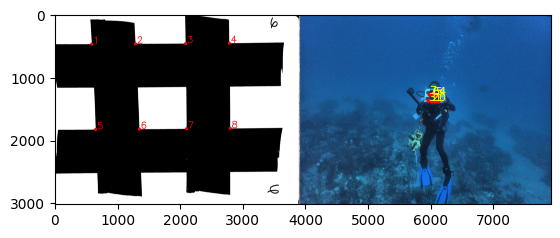

In [ ]:
async with Client(URL) as fs:
    slate_label_id = 6
    dive_slate_label = [label for label in slate_labels if label.id == slate_label_id][0]
    # dive_slate_label = random.choice(slate_labels)
    image = await fs.images.get(image_id=dive_slate_label.image_id)
    dive = await fs.dives.get(dive_id=image.dive_id)
    camera_intrinsics = await fs.cameras.get_intrinsics(dive.camera_id)
    dive_slate = dive_slates_by_id[dive.dive_slate_id]

print(dive_slate_label.id)

pdf_path = DATA_FOLDER / dive_slate.path
target_path = OUTPUT_FOLDER / f"{image.checksum}.JPG"

with pymupdf.open(pdf_path) as pdf_document:
    page: pymupdf.Page = pdf_document.load_page(0)
    pixmap: pymupdf.Pixmap = page.get_pixmap(dpi=dive_slate.dpi)
    bytes = np.frombuffer(pixmap.samples, dtype=np.uint8)

    pdf_image = bytes.reshape(pixmap.height, pixmap.width, pixmap.n)
    pdf_image = cv2.cvtColor(pdf_image, cv2.COLOR_RGB2GRAY)

    _, pdf_image = cv2.threshold(pdf_image, 125, 255, cv2.THRESH_BINARY)

    pdf_image = cv2.cvtColor(pdf_image, cv2.COLOR_GRAY2BGR)

    pdf_height, pdf_width, _ = pdf_image.shape

    scale_y = float(original_height) / float(pdf_height)
    pdf_width *= scale_y
    pdf_height *= scale_y
    pdf_image = cv2.resize(pdf_image, (int(pdf_width), int(pdf_height)))
    
img = cv2.imread(str(target_path))

reference_points = dive_slate_label.reference_points.copy()
reference_points = [(x + int(pdf_width), y) for x, y in reference_points]
reference_points = np.array(reference_points, dtype=np.float32)
print(reference_points)
plt.plot(reference_points[:, 0], reference_points[:, 1], "ro", markersize=2)
for i, (x, y) in enumerate(reference_points):
    plt.text(x, y, str(i), color="yellow", fontsize=8)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
